In [360]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

# Loading the raw data

In [361]:
raw_data = pd.read_csv('data.csv')
raw_data

,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Year,Model
0,BMW,4200.0,sedan,277,2.0,Petrol,yes,1991,320
1,Mercedes-Benz,7900.0,van,427,2.9,Diesel,yes,1999,Sprinter 212
2,Mercedes-Benz,13300.0,sedan,358,5.0,Gas,yes,2003,S 500
3,Audi,23000.0,crossover,240,4.2,Petrol,yes,2007,Q7
4,Toyota,18300.0,crossover,120,2.0,Petrol,yes,2011,Rav 4
...,...,...,...,...,...,...,...,...,...
4340,Mercedes-Benz,125000.0,sedan,9,3.0,Diesel,yes,2014,S 350
4341,BMW,6500.0,sedan,1,3.5,Petrol,yes,1999,535
4342,BMW,8000.0,sedan,194,2.0,Petrol,yes,1985,520
4343,Toyota,14200.0,sedan,31,NaN,Petrol,yes,2014,Corolla


# Preprocessing

In [362]:
# Descriptive statistics are very useful for initial exploration of the variables
raw_data.describe(include='all')

,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Year,Model
count,4345,4173.000000,4345,4345.000000,4195.000000,4345,4345,4345.000000,4345
unique,7,NaN,6,NaN,NaN,4,2,NaN,312
top,Volkswagen,NaN,sedan,NaN,NaN,Diesel,yes,NaN,E-Class
freq,936,NaN,1649,NaN,NaN,2019,3947,NaN,199
mean,NaN,19418.746935,NaN,161.237284,2.790734,NaN,NaN,2006.550058,NaN
std,NaN,25584.242620,NaN,105.705797,5.066437,NaN,NaN,6.719097,NaN
min,NaN,600.000000,NaN,0.000000,0.600000,NaN,NaN,1969.000000,NaN
25%,NaN,6999.000000,NaN,86.000000,1.800000,NaN,NaN,2003.000000,NaN
50%,NaN,11500.000000,NaN,155.000000,2.200000,NaN,NaN,2008.000000,NaN
75%,NaN,21700.000000,NaN,230.000000,3.000000,NaN,NaN,2012.000000,NaN


## Determining the variables of interest

In [363]:
data = raw_data.drop(['Model'], axis=1)
data.describe(include='all')

,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Year
count,4345,4173.000000,4345,4345.000000,4195.000000,4345,4345,4345.000000
unique,7,NaN,6,NaN,NaN,4,2,NaN
top,Volkswagen,NaN,sedan,NaN,NaN,Diesel,yes,NaN
freq,936,NaN,1649,NaN,NaN,2019,3947,NaN
mean,NaN,19418.746935,NaN,161.237284,2.790734,NaN,NaN,2006.550058
std,NaN,25584.242620,NaN,105.705797,5.066437,NaN,NaN,6.719097
min,NaN,600.000000,NaN,0.000000,0.600000,NaN,NaN,1969.000000
25%,NaN,6999.000000,NaN,86.000000,1.800000,NaN,NaN,2003.000000
50%,NaN,11500.000000,NaN,155.000000,2.200000,NaN,NaN,2008.000000
75%,NaN,21700.000000,NaN,230.000000,3.000000,NaN,NaN,2012.000000


## Missing values

In [364]:
data.isnull().sum()

Brand             0
Price           172
Body              0
Mileage           0
EngineV         150
Engine Type       0
Registration      0
Year              0
dtype: int64

In [365]:
## data.fillna(data.loc[:, ['Price', 'EngineV']].mean(), inplace=True)
# Let's simply drop all missing values
# This is not always recommended, however, when we remove less than 5% of the data, it is okay
data.dropna(axis=0, inplace=True)
data.isnull().sum()

Brand           0
Price           0
Body            0
Mileage         0
EngineV         0
Engine Type     0
Registration    0
Year            0
dtype: int64

## Outliers

In [366]:
# Outliers are a great issue for OLS, thus we must deal with them in some way
# We can deal with the problem easily by removing 0.5%, or 1% of the problematic samples

price_quantile = data.Price.quantile(0.99)
data = data.loc[data.Price < price_quantile]

mileage_quantile = data.Mileage.quantile(0.99)
data = data.loc[data.Mileage < mileage_quantile]

engineV_quantile = data.EngineV.quantile(0.99)
data = data.loc[data.EngineV < 6.5] # An area expert could help determine the outliers

year_quantile = data.Year.quantile(0.01)
data = data.loc[data.Year > year_quantile]

data.reset_index(drop=True, inplace=True)
data.describe(include='all')

,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Year
count,3867,3867.000000,3867,3867.000000,3867.000000,3867,3867,3867.000000
unique,7,NaN,6,NaN,NaN,4,2,NaN
top,Volkswagen,NaN,sedan,NaN,NaN,Diesel,yes,NaN
freq,848,NaN,1467,NaN,NaN,1807,3505,NaN
mean,NaN,18194.455679,NaN,160.542539,2.450440,NaN,NaN,2006.709853
std,NaN,19085.855165,NaN,95.633291,0.949366,NaN,NaN,6.103870
min,NaN,800.000000,NaN,0.000000,0.600000,NaN,NaN,1988.000000
25%,NaN,7200.000000,NaN,91.000000,1.800000,NaN,NaN,2003.000000
50%,NaN,11700.000000,NaN,157.000000,2.200000,NaN,NaN,2008.000000
75%,NaN,21700.000000,NaN,225.000000,3.000000,NaN,NaN,2012.000000


# Distribution Probability Function

<Axes: xlabel='Year', ylabel='Count'>

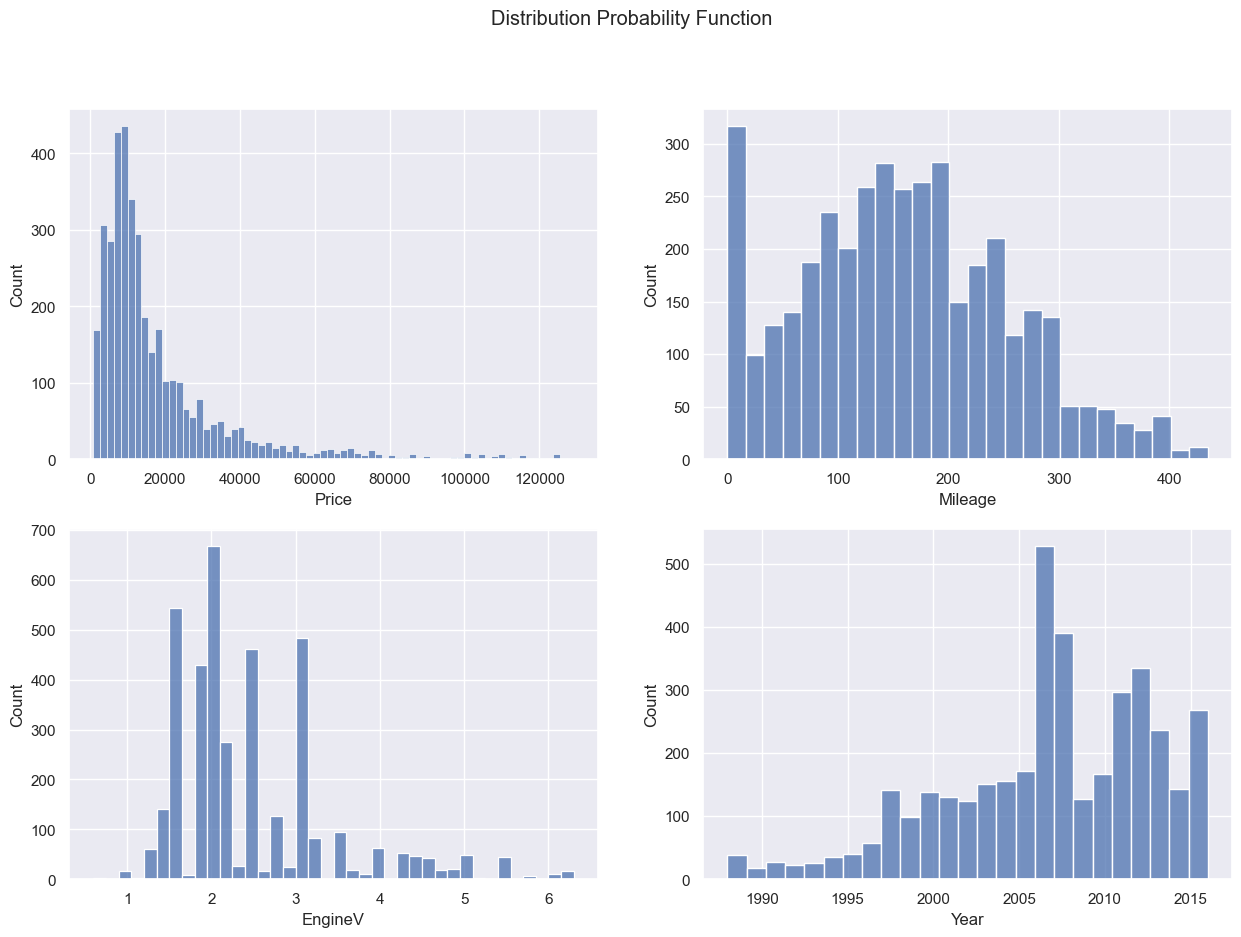

In [367]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Distribution Probability Function')

sns.histplot(data.Price, ax=axes[0][0])
sns.histplot(data.Mileage, ax=axes[0][1])
sns.histplot(data.EngineV, ax=axes[1][0])
sns.histplot(data.Year, ax=axes[1][1])

# Dummy Variables
  Is a binary variable that represents categorical data. The pandas function get_dummies maps categorical variables into dummies.

In [368]:
# It is extremely important that we drop one of the dummies, alternatively we will introduce multicollinearity
data = pd.get_dummies(data, drop_first=True) * 1
data

,Price,Mileage,EngineV,Year,Brand_BMW,Brand_Mercedes-Benz,Brand_Mitsubishi,Brand_Renault,Brand_Toyota,Brand_Volkswagen,Body_hatch,Body_other,Body_sedan,Body_vagon,Body_van,Engine Type_Gas,Engine Type_Other,Engine Type_Petrol,Registration_yes
0,4200.0,277,2.0,1991,1,0,0,0,0,0,0,0,1,0,0,0,0,1,1
1,7900.0,427,2.9,1999,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1
2,13300.0,358,5.0,2003,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1
3,23000.0,240,4.2,2007,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
4,18300.0,120,2.0,2011,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3862,11500.0,163,2.5,2008,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1
3863,17900.0,35,1.6,2014,0,0,0,0,1,0,0,0,1,0,0,0,0,1,1
3864,125000.0,9,3.0,2014,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1
3865,6500.0,1,3.5,1999,1,0,0,0,0,0,0,0,1,0,0,0,0,1,1


# Assumptions
## Linearity

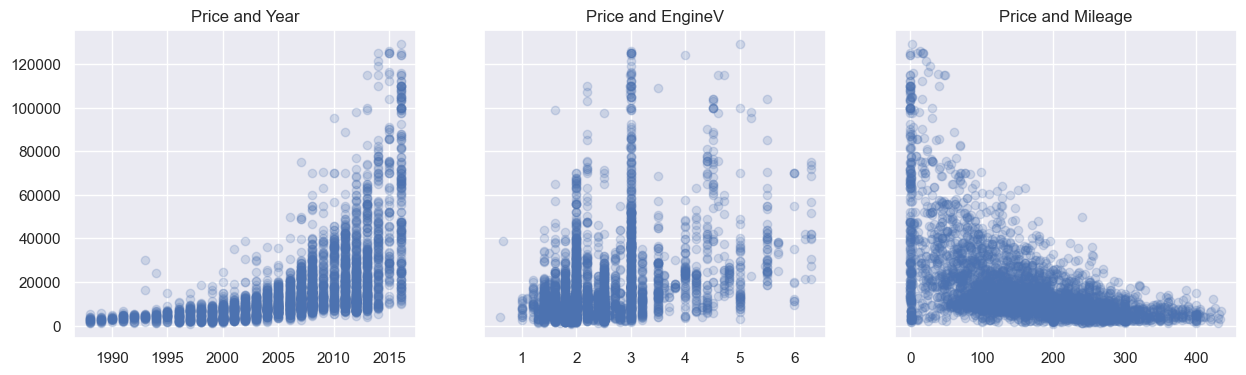

In [369]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey='all', figsize=(15, 4))

ax1.scatter(data.Year, data.Price, alpha=0.2)
ax1.set_title('Price and Year')

ax2.scatter(data.EngineV, data.Price, alpha=0.2)
ax2.set_title('Price and EngineV')

ax3.scatter(data.Mileage, data.Price, alpha=0.2)
ax3.set_title('Price and Mileage')

plt.show()

There is a exponential (non linear) relationship between the independent and dependent variables. By taking the log of one or both variables, the model can capture the percent change instead of unit change

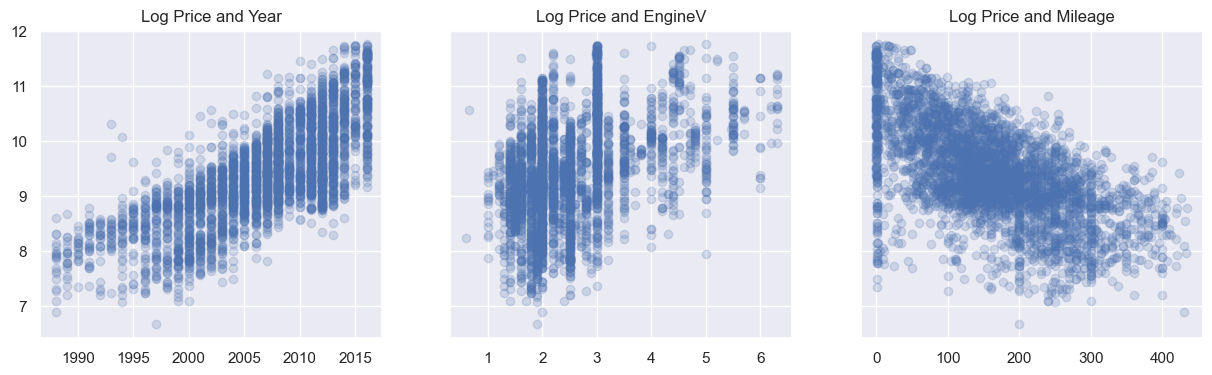

In [370]:
data['Log_Price'] = np.log(data.Price)
data.drop(['Price'], axis=1, inplace=True)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey='all', figsize=(15, 4))

ax1.scatter(data.Year, data.Log_Price, alpha=0.2)
ax1.set_title('Log Price and Year')

ax2.scatter(data.EngineV, data.Log_Price, alpha=0.2)
ax2.set_title('Log Price and EngineV')

ax3.scatter(data.Mileage, data.Log_Price, alpha=0.2)
ax3.set_title('Log Price and Mileage')

plt.show()

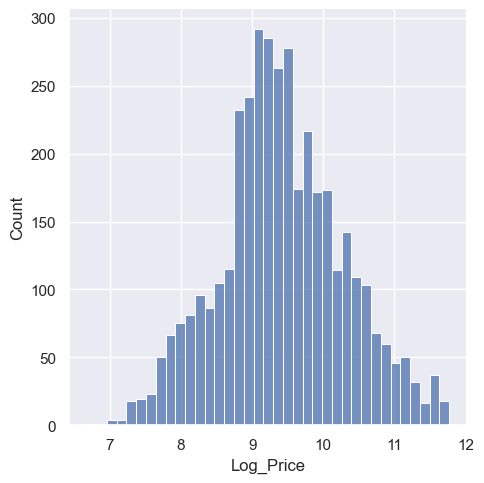

In [371]:
sns.displot(data.Log_Price)

## Multicollinearity
Occurs when two or more predictor variables are highly correlated to each other, such that they do not provide unique or independent information in the regression model. If the degree of correlation is high enough, it can cause problems when fitting and determining the exact effect of each variable on the target.

In [372]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif_variables = data

vif = pd.DataFrame(np.array(
    [[variance_inflation_factor(vif_variables.values, i) for i in range(vif_variables.shape[1])],
     np.array(vif_variables.columns)]
), index=['VIF', 'features']).T

vif

,VIF,features
0,8.917184,Mileage
1,13.957655,EngineV
2,525.466834,Year
3,2.619134,Brand_BMW
4,3.097621,Brand_Mercedes-Benz
5,2.065638,Brand_Mitsubishi
6,2.663528,Brand_Renault
7,2.500108,Brand_Toyota
8,3.527371,Brand_Volkswagen
9,1.80728,Body_hatch


Obviously, the dependent variable has a very high VIF. This implies it is most definitely **linearly correlated** with all the other variables. However, to actually assess multicollinearity for the predictors, we have to drop the target.

In [373]:
vif_variables = data.drop(['Log_Price'], axis=1)

vif = pd.DataFrame(np.array(
    [[variance_inflation_factor(vif_variables.values, i) for i in range(vif_variables.shape[1])],
     np.array(vif_variables.columns)]
), index=['VIF', 'features']).T

vif

,VIF,features
0,4.804166,Mileage
1,12.073513,EngineV
2,44.380854,Year
3,2.617193,Brand_BMW
4,3.097007,Brand_Mercedes-Benz
5,1.951411,Brand_Mitsubishi
6,2.449007,Brand_Renault
7,2.477904,Brand_Toyota
8,3.467673,Brand_Volkswagen
9,1.683194,Body_hatch


In [374]:
data.drop(['Year'], axis=1, inplace=True)
vif_variables = data.drop(['Log_Price'], axis=1)

vif = pd.DataFrame(np.array(
    [[variance_inflation_factor(vif_variables.values, i) for i in range(vif_variables.shape[1])],
     np.array(vif_variables.columns)]
), index=['VIF', 'features']).T

vif

,VIF,features
0,4.459662,Mileage
1,7.841729,EngineV
2,2.294007,Brand_BMW
3,2.868649,Brand_Mercedes-Benz
4,1.641712,Brand_Mitsubishi
5,2.086774,Brand_Renault
6,2.162166,Brand_Toyota
7,2.844515,Brand_Volkswagen
8,1.46426,Body_hatch
9,1.534059,Body_other


# Linear Regression Model

## Inputs and Targets

In [375]:
targets = data.Log_Price
inputs = data.drop(['Log_Price'], axis=1)

## Scaling

In [376]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
inputs_scaled = scaler.fit_transform(inputs)

## Train test split

In [377]:
from sklearn.model_selection import train_test_split

# By default, 25% data is test set and 75% data goes into training set.
x_train, x_test, y_train, y_test = train_test_split(inputs_scaled, targets, test_size=0.2, random_state=365) ## 42

x_train = pd.DataFrame(x_train).reset_index(drop=True)
x_test = pd.DataFrame(x_test).reset_index(drop=True)
y_train = pd.DataFrame(y_train).reset_index(drop=True)
y_test = pd.DataFrame(y_test).reset_index(drop=True)

## Creating the Regression

In [378]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression()
reg.fit(x_train, y_train)

LinearRegression()

## Testing

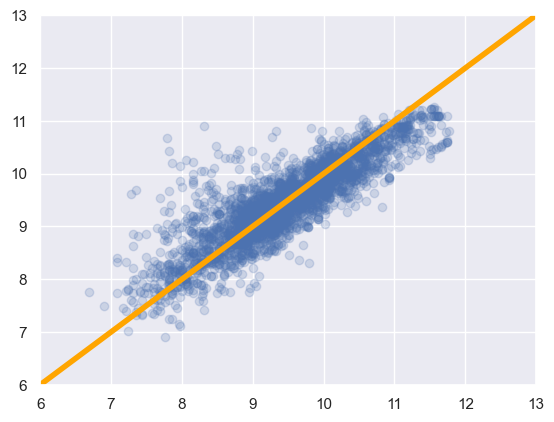

In [379]:
predicted_y = reg.predict(x_train)

# The simplest way to compare the targets (y_train) and the predictions (predicted_y) is to plot them on a scatter plot
# The closer the points to the 45-degree line, the better the prediction

plt.scatter(y_train, predicted_y, alpha=0.2)
plt.plot([0,15], [0,15], lw=4, c='orange')

plt.xlim(6,13)
plt.ylim(6,13)

plt.show()

## Residual Distribution

Text(0.5, 1.0, 'Residuals PDF')

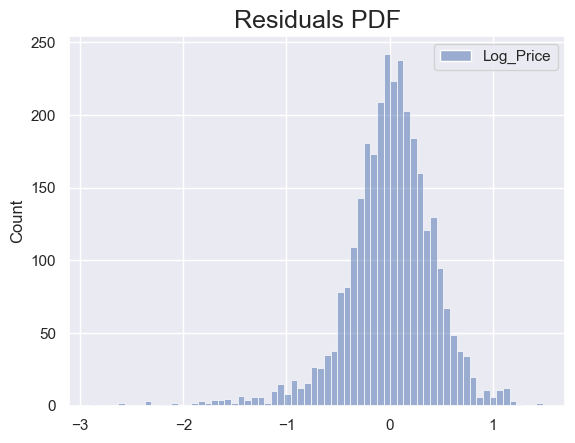

In [380]:
# In the best case scenario this plot should be normally distributed
sns.histplot(y_train - predicted_y)
plt.title('Residuals PDF', size=18)

## Adjusted R Squared
Measures the proportion of change in the dependent variable that is predictable from the independent variable, while adjusting for the numbers of predictors

$R^2_{adj} = 1 - (1-R^2)*\frac{n-1}{n-p-1}$

In [381]:
r2 = reg.score(x_train, y_train)
n = x_train.shape[0]
p = x_train.shape[1]

adj_r2 = 1-(1-r2)*(n-1)/(n-p-1)
adj_r2

0.7435868037811093

## Feature Selection

In [382]:
from sklearn.feature_selection import f_regression

p_values = f_regression(inputs, targets)[1]
p_values

array([0.00000000e+000, 2.65855077e-158, 1.80420259e-008, 2.62901969e-015,
       4.79766231e-007, 5.52787198e-039, 1.87306983e-020, 4.05331961e-011,
       5.26975221e-018, 3.43978741e-002, 1.81728039e-016, 2.77241307e-029,
       1.50990623e-014, 5.15395626e-008, 5.46069820e-002, 8.43206723e-003,
       9.25417095e-205])

## Weights and Bias

In [383]:
features = np.append('Bias', inputs.columns.values)
weights = np.append(reg.intercept_, reg.coef_)

reg_summary = pd.DataFrame(features, columns=['Features'])
reg_summary['Weights'] = weights

reg_summary

,Features,Weights
0,Bias,9.415239
1,Mileage,-0.448713
2,EngineV,0.209035
3,Brand_BMW,0.014250
4,Brand_Mercedes-Benz,0.012882
5,Brand_Mitsubishi,-0.140552
6,Brand_Renault,-0.179909
7,Brand_Toyota,-0.060550
8,Brand_Volkswagen,-0.089924
9,Body_hatch,-0.145469


# Testing

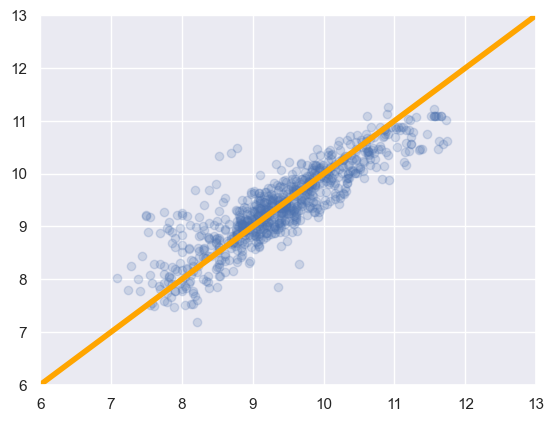

In [384]:
predicted_y_test = reg.predict(x_test)

plt.scatter(y_test, predicted_y_test, alpha=0.2)
plt.plot([0,15], [0,15], lw=4, c='orange')

plt.xlim(6,13)
plt.ylim(6,13)

plt.show()

In [385]:
reg_performance = pd.DataFrame(np.exp(predicted_y_test), columns=['Predicted'])
reg_performance['Target'] = np.exp(y_test)
reg_performance['Residual'] = reg_performance['Target'] - reg_performance['Predicted']
reg_performance['Difference%'] = np.absolute(reg_performance['Residual'] / reg_performance['Target'] * 100)
reg_performance.describe()

,Predicted,Target,Residual,Difference%
count,774.000000,774.000000,774.000000,774.000000
mean,15946.760167,18165.817106,2219.056939,36.256693
std,13133.197604,19967.858908,10871.218143,55.066507
min,1320.562768,1200.000000,-29456.498331,0.062794
25%,7413.644234,6900.000000,-2044.191251,12.108022
50%,11568.168859,11600.000000,142.518577,23.467728
75%,20162.408805,20500.000000,3147.343497,39.563570
max,77403.055224,126000.000000,85106.162329,512.688080


In [386]:
reg_performance

,Predicted,Target,Residual,Difference%
0,10685.501696,2300.0,-8385.501696,364.587030
1,3499.255242,2800.0,-699.255242,24.973402
2,7553.285218,2500.0,-5053.285218,202.131409
3,7463.963017,6400.0,-1063.963017,16.624422
4,11353.490075,9150.0,-2203.490075,24.081859
...,...,...,...,...
769,29651.726363,29500.0,-151.726363,0.514327
770,10732.071179,9600.0,-1132.071179,11.792408
771,13922.446953,18300.0,4377.553047,23.921055
772,27487.751303,68500.0,41012.248697,59.871896
